### PSF Investigation

In [1]:
# Imports
from astropy.table import Table
import lsst.daf.butler as dafButler
import glob
import lsst.afw.table as afwTable
import matplotlib as mpl
import matplotlib.pyplot as plt
from modelling_research.plotting import plotjoint_running_percentiles
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [2]:
# Config
hsc = True
overwrite = False
gen2to3 = True
filter_inexact_psf = True
filter_interpolated = True
midfix = '_gen2to3' if gen2to3 else ''
savepre = (f'/project/dtaranu/{"hsc" if hsc else "dc2_gen3"}'
           f'/coaddpsf/w_2021_{"06" if hsc else "04"}{midfix}/')
if not os.path.isdir(savepre):
    os.mkdir(savepre)
savepost = '.parq'
bands = ['g', 'r', 'i']
if hsc:
    butler = dafButler.Butler('/repo/main', collections='HSC/runs/RC2/w_2021_06/DM-28654')
    n_patches = 81
    scale_pix = 0.168
    tracts = [9615, 9697]
    # It's pointless to include COSMOS if these flags are used as 90%+ of coadd stars have them
    if not filter_inexact_psf and not filter_interpolated:
        tracts.append(9813)
    limxs = {band: x for band, x in zip(bands, ((0.525, 1.275), (0.35, 1.0), (0.35, 1.0),))}
    limsfrac = (-0.05, 0.05)
else:
    butler = dafButler.Butler('/repo/dc2', collections='2.2i/runs/test-med-1/w_2021_04/DM-28453')
    tracts = [3828, 3829]
    n_patches = 49
    scale_pix = 0.2
    filter_inexact_psf = True
    filter_interpolated = True
    limxs = {band: x for band, x in zip(bands, ((0.6, 1.2), (0.65, 0.95), (0.65, 0.95),))}
    limsfrac = (-0.025, 0.025)
patches = list(range(n_patches))

In [3]:
# Plot settings
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize'] = 10, 20
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})
sns.set_style('dark')

In [4]:
# Take a sourceCatalog and turn it into a condensed parquet table
def make_summary(butler, type_cat=None, **kwargs):
    if type_cat is None:
        type_cat = 'deepCoadd_meas'
    try:
        src = butler.get(type_cat, **kwargs)
    except Exception as e:
        print(f'Failed to butler.get({type_cat}, {kwargs}) due to {e}')
        return None

    mask = src['calib_psf_used']
    n_psf = np.sum(mask)
    stars = src[mask]
    
    mask = None
    flags = [
        'base_PixelFlags_flag_clipped',
        'base_PixelFlags_flag_saturated',
    ]
    if filter_inexact_psf:
        flags.append('base_PixelFlags_flag_inexact_psf')
    if filter_interpolated:
        flags.append('base_PixelFlags_flag_interpolated')
    for flag in flags:
        if mask is None:
            mask = ~stars[flag]
        else:
            mask = mask & ~stars[flag]
        print(f'Flag {flag} filters {np.sum(stars[flag])}/{n_psf} for dataId: {kwargs}')
    print(f'Selected {np.sum(mask)}/{n_psf}')
    if np.sum(mask)==0:
        print('No data')
        return None
    stars = stars[mask]
    starIxx = stars['base_SdssShape_xx']
    starIxy = stars['base_SdssShape_xy']
    starIyy = stars['base_SdssShape_yy']
    modelIxx = stars['base_SdssShape_psf_xx']
    modelIxy = stars['base_SdssShape_psf_xy']
    modelIyy = stars['base_SdssShape_psf_yy']
    data = {}
    data['starE1'] = (starIxx-starIyy)/(starIxx+starIyy)
    data['starE2'] = (2*starIxy)/(starIxx+starIyy)
    data['starSize'] = np.sqrt(0.5*(starIxx + starIyy))*2.354820045*scale_pix
    data['modelE1'] = (modelIxx-modelIyy)/(modelIxx+modelIyy)
    data['modelE2'] = (2*modelIxy)/(modelIxx+modelIyy)
    data['modelSize'] = np.sqrt(0.5*(modelIxx + modelIyy))*2.354820045*scale_pix
    data['ra'] = [a.getCoord().getRa().asDegrees() for a in stars]
    data['dec'] = [a.getCoord().getDec().asDegrees() for a in stars]
    data['fluxPsf'] = stars['base_PsfFlux_instFlux']
    data['fluxPsfErr'] = stars['base_PsfFlux_instFluxErr']
    data['fluxCmodel'] = stars['modelfit_CModel_instFlux']
    data['fluxCmodelErr'] = stars['modelfit_CModel_instFluxErr']
    df = pd.DataFrame(data)
    return df

def make_table(band, tracts, patches, **kwargs):
    data=[]
    for tract in tracts:
        for patch in patches:
            print(f'Making summary for band={band}, tract={tract}, patch={patch}')
            result = make_summary(band=band, tract=tract, patch=patch, **kwargs)
            if result is None:
                continue
            data.append(result)
    table = pd.concat(data)
    return table

In [5]:
# Read/write data
data = {}
for band in bands:
    desc = (f'{",".join((str(x) for x in tracts))}_{band}_filt_inexact'
            f'{int(filter_inexact_psf)}_interp{int(filter_interpolated)}')
    savefile = f'{savepre}{desc}{savepost}'
    if overwrite or not os.path.exists(savefile):
        print(f'Generating {savefile} for band={band}, tracts={tracts}, patches={patches}')
        table = make_table(band, tracts, patches, butler=butler)
        table.to_parquet(savefile)
        data[band] = table
    else:
        print(f'Reading {savefile}')
        data[band] = pd.read_parquet(savefile)

Generating /project/dtaranu/hsc/coaddpsf/w_2021_06_gen2to3/9615,9697_g_filt_inexact1_interp1.parq for band=g, tracts=[9615, 9697], patches=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
Making summary for band=g, tract=9615, patch=0
Flag base_PixelFlags_flag_clipped filters 38/494 for dataId: {'band': 'g', 'tract': 9615, 'patch': 0}
Flag base_PixelFlags_flag_saturated filters 7/494 for dataId: {'band': 'g', 'tract': 9615, 'patch': 0}
Flag base_PixelFlags_flag_inexact_psf filters 214/494 for dataId: {'band': 'g', 'tract': 9615, 'patch': 0}
Flag base_PixelFlags_flag_interpolated filters 100/494 for dataId: {'band': 'g', 'tract': 9615, 'patch': 0}
Selected 236/494
Making summary for band=g, tract=9615, patch=1
Flag base_Pixel

Flag base_PixelFlags_flag_clipped filters 35/492 for dataId: {'band': 'g', 'tract': 9615, 'patch': 16}
Flag base_PixelFlags_flag_saturated filters 2/492 for dataId: {'band': 'g', 'tract': 9615, 'patch': 16}
Flag base_PixelFlags_flag_inexact_psf filters 168/492 for dataId: {'band': 'g', 'tract': 9615, 'patch': 16}
Flag base_PixelFlags_flag_interpolated filters 94/492 for dataId: {'band': 'g', 'tract': 9615, 'patch': 16}
Selected 264/492
Making summary for band=g, tract=9615, patch=17
Flag base_PixelFlags_flag_clipped filters 16/453 for dataId: {'band': 'g', 'tract': 9615, 'patch': 17}
Flag base_PixelFlags_flag_saturated filters 5/453 for dataId: {'band': 'g', 'tract': 9615, 'patch': 17}
Flag base_PixelFlags_flag_inexact_psf filters 187/453 for dataId: {'band': 'g', 'tract': 9615, 'patch': 17}
Flag base_PixelFlags_flag_interpolated filters 81/453 for dataId: {'band': 'g', 'tract': 9615, 'patch': 17}
Selected 222/453
Making summary for band=g, tract=9615, patch=18
Flag base_PixelFlags_fla

Flag base_PixelFlags_flag_clipped filters 18/476 for dataId: {'band': 'g', 'tract': 9615, 'patch': 33}
Flag base_PixelFlags_flag_saturated filters 4/476 for dataId: {'band': 'g', 'tract': 9615, 'patch': 33}
Flag base_PixelFlags_flag_inexact_psf filters 187/476 for dataId: {'band': 'g', 'tract': 9615, 'patch': 33}
Flag base_PixelFlags_flag_interpolated filters 108/476 for dataId: {'band': 'g', 'tract': 9615, 'patch': 33}
Selected 224/476
Making summary for band=g, tract=9615, patch=34
Flag base_PixelFlags_flag_clipped filters 18/413 for dataId: {'band': 'g', 'tract': 9615, 'patch': 34}
Flag base_PixelFlags_flag_saturated filters 4/413 for dataId: {'band': 'g', 'tract': 9615, 'patch': 34}
Flag base_PixelFlags_flag_inexact_psf filters 156/413 for dataId: {'band': 'g', 'tract': 9615, 'patch': 34}
Flag base_PixelFlags_flag_interpolated filters 76/413 for dataId: {'band': 'g', 'tract': 9615, 'patch': 34}
Selected 215/413
Making summary for band=g, tract=9615, patch=35
Flag base_PixelFlags_fl

Flag base_PixelFlags_flag_clipped filters 29/509 for dataId: {'band': 'g', 'tract': 9615, 'patch': 50}
Flag base_PixelFlags_flag_saturated filters 9/509 for dataId: {'band': 'g', 'tract': 9615, 'patch': 50}
Flag base_PixelFlags_flag_inexact_psf filters 219/509 for dataId: {'band': 'g', 'tract': 9615, 'patch': 50}
Flag base_PixelFlags_flag_interpolated filters 111/509 for dataId: {'band': 'g', 'tract': 9615, 'patch': 50}
Selected 236/509
Making summary for band=g, tract=9615, patch=51
Flag base_PixelFlags_flag_clipped filters 38/452 for dataId: {'band': 'g', 'tract': 9615, 'patch': 51}
Flag base_PixelFlags_flag_saturated filters 2/452 for dataId: {'band': 'g', 'tract': 9615, 'patch': 51}
Flag base_PixelFlags_flag_inexact_psf filters 145/452 for dataId: {'band': 'g', 'tract': 9615, 'patch': 51}
Flag base_PixelFlags_flag_interpolated filters 50/452 for dataId: {'band': 'g', 'tract': 9615, 'patch': 51}
Selected 276/452
Making summary for band=g, tract=9615, patch=52
Flag base_PixelFlags_fl

Flag base_PixelFlags_flag_clipped filters 39/429 for dataId: {'band': 'g', 'tract': 9615, 'patch': 67}
Flag base_PixelFlags_flag_saturated filters 9/429 for dataId: {'band': 'g', 'tract': 9615, 'patch': 67}
Flag base_PixelFlags_flag_inexact_psf filters 139/429 for dataId: {'band': 'g', 'tract': 9615, 'patch': 67}
Flag base_PixelFlags_flag_interpolated filters 87/429 for dataId: {'band': 'g', 'tract': 9615, 'patch': 67}
Selected 234/429
Making summary for band=g, tract=9615, patch=68
Flag base_PixelFlags_flag_clipped filters 8/460 for dataId: {'band': 'g', 'tract': 9615, 'patch': 68}
Flag base_PixelFlags_flag_saturated filters 11/460 for dataId: {'band': 'g', 'tract': 9615, 'patch': 68}
Flag base_PixelFlags_flag_inexact_psf filters 128/460 for dataId: {'band': 'g', 'tract': 9615, 'patch': 68}
Flag base_PixelFlags_flag_interpolated filters 48/460 for dataId: {'band': 'g', 'tract': 9615, 'patch': 68}
Selected 297/460
Making summary for band=g, tract=9615, patch=69
Flag base_PixelFlags_fla

Flag base_PixelFlags_flag_clipped filters 43/297 for dataId: {'band': 'g', 'tract': 9697, 'patch': 3}
Flag base_PixelFlags_flag_saturated filters 4/297 for dataId: {'band': 'g', 'tract': 9697, 'patch': 3}
Flag base_PixelFlags_flag_inexact_psf filters 130/297 for dataId: {'band': 'g', 'tract': 9697, 'patch': 3}
Flag base_PixelFlags_flag_interpolated filters 48/297 for dataId: {'band': 'g', 'tract': 9697, 'patch': 3}
Selected 143/297
Making summary for band=g, tract=9697, patch=4
Flag base_PixelFlags_flag_clipped filters 29/320 for dataId: {'band': 'g', 'tract': 9697, 'patch': 4}
Flag base_PixelFlags_flag_saturated filters 4/320 for dataId: {'band': 'g', 'tract': 9697, 'patch': 4}
Flag base_PixelFlags_flag_inexact_psf filters 178/320 for dataId: {'band': 'g', 'tract': 9697, 'patch': 4}
Flag base_PixelFlags_flag_interpolated filters 81/320 for dataId: {'band': 'g', 'tract': 9697, 'patch': 4}
Selected 120/320
Making summary for band=g, tract=9697, patch=5
Flag base_PixelFlags_flag_clipped 

Flag base_PixelFlags_flag_clipped filters 63/323 for dataId: {'band': 'g', 'tract': 9697, 'patch': 20}
Flag base_PixelFlags_flag_saturated filters 8/323 for dataId: {'band': 'g', 'tract': 9697, 'patch': 20}
Flag base_PixelFlags_flag_inexact_psf filters 151/323 for dataId: {'band': 'g', 'tract': 9697, 'patch': 20}
Flag base_PixelFlags_flag_interpolated filters 86/323 for dataId: {'band': 'g', 'tract': 9697, 'patch': 20}
Selected 130/323
Making summary for band=g, tract=9697, patch=21
Flag base_PixelFlags_flag_clipped filters 57/314 for dataId: {'band': 'g', 'tract': 9697, 'patch': 21}
Flag base_PixelFlags_flag_saturated filters 6/314 for dataId: {'band': 'g', 'tract': 9697, 'patch': 21}
Flag base_PixelFlags_flag_inexact_psf filters 150/314 for dataId: {'band': 'g', 'tract': 9697, 'patch': 21}
Flag base_PixelFlags_flag_interpolated filters 71/314 for dataId: {'band': 'g', 'tract': 9697, 'patch': 21}
Selected 132/314
Making summary for band=g, tract=9697, patch=22
Flag base_PixelFlags_fla

Flag base_PixelFlags_flag_clipped filters 35/355 for dataId: {'band': 'g', 'tract': 9697, 'patch': 37}
Flag base_PixelFlags_flag_saturated filters 2/355 for dataId: {'band': 'g', 'tract': 9697, 'patch': 37}
Flag base_PixelFlags_flag_inexact_psf filters 167/355 for dataId: {'band': 'g', 'tract': 9697, 'patch': 37}
Flag base_PixelFlags_flag_interpolated filters 61/355 for dataId: {'band': 'g', 'tract': 9697, 'patch': 37}
Selected 153/355
Making summary for band=g, tract=9697, patch=38
Flag base_PixelFlags_flag_clipped filters 20/329 for dataId: {'band': 'g', 'tract': 9697, 'patch': 38}
Flag base_PixelFlags_flag_saturated filters 1/329 for dataId: {'band': 'g', 'tract': 9697, 'patch': 38}
Flag base_PixelFlags_flag_inexact_psf filters 155/329 for dataId: {'band': 'g', 'tract': 9697, 'patch': 38}
Flag base_PixelFlags_flag_interpolated filters 83/329 for dataId: {'band': 'g', 'tract': 9697, 'patch': 38}
Selected 139/329
Making summary for band=g, tract=9697, patch=39
Flag base_PixelFlags_fla

Flag base_PixelFlags_flag_clipped filters 9/259 for dataId: {'band': 'g', 'tract': 9697, 'patch': 54}
Flag base_PixelFlags_flag_saturated filters 5/259 for dataId: {'band': 'g', 'tract': 9697, 'patch': 54}
Flag base_PixelFlags_flag_inexact_psf filters 123/259 for dataId: {'band': 'g', 'tract': 9697, 'patch': 54}
Flag base_PixelFlags_flag_interpolated filters 54/259 for dataId: {'band': 'g', 'tract': 9697, 'patch': 54}
Selected 115/259
Making summary for band=g, tract=9697, patch=55
Flag base_PixelFlags_flag_clipped filters 13/241 for dataId: {'band': 'g', 'tract': 9697, 'patch': 55}
Flag base_PixelFlags_flag_saturated filters 9/241 for dataId: {'band': 'g', 'tract': 9697, 'patch': 55}
Flag base_PixelFlags_flag_inexact_psf filters 154/241 for dataId: {'band': 'g', 'tract': 9697, 'patch': 55}
Flag base_PixelFlags_flag_interpolated filters 97/241 for dataId: {'band': 'g', 'tract': 9697, 'patch': 55}
Selected 47/241
Making summary for band=g, tract=9697, patch=56
Flag base_PixelFlags_flag_

Flag base_PixelFlags_flag_clipped filters 28/331 for dataId: {'band': 'g', 'tract': 9697, 'patch': 71}
Flag base_PixelFlags_flag_saturated filters 5/331 for dataId: {'band': 'g', 'tract': 9697, 'patch': 71}
Flag base_PixelFlags_flag_inexact_psf filters 221/331 for dataId: {'band': 'g', 'tract': 9697, 'patch': 71}
Flag base_PixelFlags_flag_interpolated filters 109/331 for dataId: {'band': 'g', 'tract': 9697, 'patch': 71}
Selected 79/331
Making summary for band=g, tract=9697, patch=72
Flag base_PixelFlags_flag_clipped filters 19/301 for dataId: {'band': 'g', 'tract': 9697, 'patch': 72}
Flag base_PixelFlags_flag_saturated filters 6/301 for dataId: {'band': 'g', 'tract': 9697, 'patch': 72}
Flag base_PixelFlags_flag_inexact_psf filters 117/301 for dataId: {'band': 'g', 'tract': 9697, 'patch': 72}
Flag base_PixelFlags_flag_interpolated filters 66/301 for dataId: {'band': 'g', 'tract': 9697, 'patch': 72}
Selected 151/301
Making summary for band=g, tract=9697, patch=73
Flag base_PixelFlags_fla

Flag base_PixelFlags_flag_clipped filters 218/617 for dataId: {'band': 'r', 'tract': 9615, 'patch': 6}
Flag base_PixelFlags_flag_saturated filters 32/617 for dataId: {'band': 'r', 'tract': 9615, 'patch': 6}
Flag base_PixelFlags_flag_inexact_psf filters 363/617 for dataId: {'band': 'r', 'tract': 9615, 'patch': 6}
Flag base_PixelFlags_flag_interpolated filters 94/617 for dataId: {'band': 'r', 'tract': 9615, 'patch': 6}
Selected 211/617
Making summary for band=r, tract=9615, patch=7
Flag base_PixelFlags_flag_clipped filters 196/678 for dataId: {'band': 'r', 'tract': 9615, 'patch': 7}
Flag base_PixelFlags_flag_saturated filters 23/678 for dataId: {'band': 'r', 'tract': 9615, 'patch': 7}
Flag base_PixelFlags_flag_inexact_psf filters 354/678 for dataId: {'band': 'r', 'tract': 9615, 'patch': 7}
Flag base_PixelFlags_flag_interpolated filters 106/678 for dataId: {'band': 'r', 'tract': 9615, 'patch': 7}
Selected 292/678
Making summary for band=r, tract=9615, patch=8
Flag base_PixelFlags_flag_cli

Flag base_PixelFlags_flag_clipped filters 134/646 for dataId: {'band': 'r', 'tract': 9615, 'patch': 23}
Flag base_PixelFlags_flag_saturated filters 21/646 for dataId: {'band': 'r', 'tract': 9615, 'patch': 23}
Flag base_PixelFlags_flag_inexact_psf filters 347/646 for dataId: {'band': 'r', 'tract': 9615, 'patch': 23}
Flag base_PixelFlags_flag_interpolated filters 122/646 for dataId: {'band': 'r', 'tract': 9615, 'patch': 23}
Selected 241/646
Making summary for band=r, tract=9615, patch=24
Flag base_PixelFlags_flag_clipped filters 242/673 for dataId: {'band': 'r', 'tract': 9615, 'patch': 24}
Flag base_PixelFlags_flag_saturated filters 29/673 for dataId: {'band': 'r', 'tract': 9615, 'patch': 24}
Flag base_PixelFlags_flag_inexact_psf filters 433/673 for dataId: {'band': 'r', 'tract': 9615, 'patch': 24}
Flag base_PixelFlags_flag_interpolated filters 174/673 for dataId: {'band': 'r', 'tract': 9615, 'patch': 24}
Selected 175/673
Making summary for band=r, tract=9615, patch=25
Flag base_PixelFla

Flag base_PixelFlags_flag_clipped filters 179/716 for dataId: {'band': 'r', 'tract': 9615, 'patch': 40}
Flag base_PixelFlags_flag_saturated filters 42/716 for dataId: {'band': 'r', 'tract': 9615, 'patch': 40}
Flag base_PixelFlags_flag_inexact_psf filters 379/716 for dataId: {'band': 'r', 'tract': 9615, 'patch': 40}
Flag base_PixelFlags_flag_interpolated filters 130/716 for dataId: {'band': 'r', 'tract': 9615, 'patch': 40}
Selected 289/716
Making summary for band=r, tract=9615, patch=41
Flag base_PixelFlags_flag_clipped filters 87/667 for dataId: {'band': 'r', 'tract': 9615, 'patch': 41}
Flag base_PixelFlags_flag_saturated filters 22/667 for dataId: {'band': 'r', 'tract': 9615, 'patch': 41}
Flag base_PixelFlags_flag_inexact_psf filters 233/667 for dataId: {'band': 'r', 'tract': 9615, 'patch': 41}
Flag base_PixelFlags_flag_interpolated filters 86/667 for dataId: {'band': 'r', 'tract': 9615, 'patch': 41}
Selected 398/667
Making summary for band=r, tract=9615, patch=42
Flag base_PixelFlags

Flag base_PixelFlags_flag_clipped filters 176/693 for dataId: {'band': 'r', 'tract': 9615, 'patch': 57}
Flag base_PixelFlags_flag_saturated filters 19/693 for dataId: {'band': 'r', 'tract': 9615, 'patch': 57}
Flag base_PixelFlags_flag_inexact_psf filters 293/693 for dataId: {'band': 'r', 'tract': 9615, 'patch': 57}
Flag base_PixelFlags_flag_interpolated filters 94/693 for dataId: {'band': 'r', 'tract': 9615, 'patch': 57}
Selected 359/693
Making summary for band=r, tract=9615, patch=58
Flag base_PixelFlags_flag_clipped filters 156/636 for dataId: {'band': 'r', 'tract': 9615, 'patch': 58}
Flag base_PixelFlags_flag_saturated filters 26/636 for dataId: {'band': 'r', 'tract': 9615, 'patch': 58}
Flag base_PixelFlags_flag_inexact_psf filters 308/636 for dataId: {'band': 'r', 'tract': 9615, 'patch': 58}
Flag base_PixelFlags_flag_interpolated filters 116/636 for dataId: {'band': 'r', 'tract': 9615, 'patch': 58}
Selected 278/636
Making summary for band=r, tract=9615, patch=59
Flag base_PixelFlag

Flag base_PixelFlags_flag_clipped filters 43/603 for dataId: {'band': 'r', 'tract': 9615, 'patch': 74}
Flag base_PixelFlags_flag_saturated filters 26/603 for dataId: {'band': 'r', 'tract': 9615, 'patch': 74}
Flag base_PixelFlags_flag_inexact_psf filters 192/603 for dataId: {'band': 'r', 'tract': 9615, 'patch': 74}
Flag base_PixelFlags_flag_interpolated filters 72/603 for dataId: {'band': 'r', 'tract': 9615, 'patch': 74}
Selected 364/603
Making summary for band=r, tract=9615, patch=75
Flag base_PixelFlags_flag_clipped filters 141/659 for dataId: {'band': 'r', 'tract': 9615, 'patch': 75}
Flag base_PixelFlags_flag_saturated filters 23/659 for dataId: {'band': 'r', 'tract': 9615, 'patch': 75}
Flag base_PixelFlags_flag_inexact_psf filters 276/659 for dataId: {'band': 'r', 'tract': 9615, 'patch': 75}
Flag base_PixelFlags_flag_interpolated filters 85/659 for dataId: {'band': 'r', 'tract': 9615, 'patch': 75}
Selected 349/659
Making summary for band=r, tract=9615, patch=76
Flag base_PixelFlags_

Flag base_PixelFlags_flag_clipped filters 107/417 for dataId: {'band': 'r', 'tract': 9697, 'patch': 10}
Flag base_PixelFlags_flag_saturated filters 43/417 for dataId: {'band': 'r', 'tract': 9697, 'patch': 10}
Flag base_PixelFlags_flag_inexact_psf filters 284/417 for dataId: {'band': 'r', 'tract': 9697, 'patch': 10}
Flag base_PixelFlags_flag_interpolated filters 130/417 for dataId: {'band': 'r', 'tract': 9697, 'patch': 10}
Selected 98/417
Making summary for band=r, tract=9697, patch=11
Flag base_PixelFlags_flag_clipped filters 116/432 for dataId: {'band': 'r', 'tract': 9697, 'patch': 11}
Flag base_PixelFlags_flag_saturated filters 15/432 for dataId: {'band': 'r', 'tract': 9697, 'patch': 11}
Flag base_PixelFlags_flag_inexact_psf filters 252/432 for dataId: {'band': 'r', 'tract': 9697, 'patch': 11}
Flag base_PixelFlags_flag_interpolated filters 127/432 for dataId: {'band': 'r', 'tract': 9697, 'patch': 11}
Selected 126/432
Making summary for band=r, tract=9697, patch=12
Flag base_PixelFlag

Flag base_PixelFlags_flag_clipped filters 90/476 for dataId: {'band': 'r', 'tract': 9697, 'patch': 27}
Flag base_PixelFlags_flag_saturated filters 25/476 for dataId: {'band': 'r', 'tract': 9697, 'patch': 27}
Flag base_PixelFlags_flag_inexact_psf filters 239/476 for dataId: {'band': 'r', 'tract': 9697, 'patch': 27}
Flag base_PixelFlags_flag_interpolated filters 110/476 for dataId: {'band': 'r', 'tract': 9697, 'patch': 27}
Selected 191/476
Making summary for band=r, tract=9697, patch=28
Flag base_PixelFlags_flag_clipped filters 91/439 for dataId: {'band': 'r', 'tract': 9697, 'patch': 28}
Flag base_PixelFlags_flag_saturated filters 8/439 for dataId: {'band': 'r', 'tract': 9697, 'patch': 28}
Flag base_PixelFlags_flag_inexact_psf filters 212/439 for dataId: {'band': 'r', 'tract': 9697, 'patch': 28}
Flag base_PixelFlags_flag_interpolated filters 72/439 for dataId: {'band': 'r', 'tract': 9697, 'patch': 28}
Selected 200/439
Making summary for band=r, tract=9697, patch=29
Flag base_PixelFlags_f

Flag base_PixelFlags_flag_clipped filters 78/510 for dataId: {'band': 'r', 'tract': 9697, 'patch': 44}
Flag base_PixelFlags_flag_saturated filters 4/510 for dataId: {'band': 'r', 'tract': 9697, 'patch': 44}
Flag base_PixelFlags_flag_inexact_psf filters 216/510 for dataId: {'band': 'r', 'tract': 9697, 'patch': 44}
Flag base_PixelFlags_flag_interpolated filters 99/510 for dataId: {'band': 'r', 'tract': 9697, 'patch': 44}
Selected 239/510
Making summary for band=r, tract=9697, patch=45
Flag base_PixelFlags_flag_clipped filters 26/488 for dataId: {'band': 'r', 'tract': 9697, 'patch': 45}
Flag base_PixelFlags_flag_saturated filters 20/488 for dataId: {'band': 'r', 'tract': 9697, 'patch': 45}
Flag base_PixelFlags_flag_inexact_psf filters 201/488 for dataId: {'band': 'r', 'tract': 9697, 'patch': 45}
Flag base_PixelFlags_flag_interpolated filters 78/488 for dataId: {'band': 'r', 'tract': 9697, 'patch': 45}
Selected 245/488
Making summary for band=r, tract=9697, patch=46
Flag base_PixelFlags_fl

Flag base_PixelFlags_flag_clipped filters 64/505 for dataId: {'band': 'r', 'tract': 9697, 'patch': 61}
Flag base_PixelFlags_flag_saturated filters 13/505 for dataId: {'band': 'r', 'tract': 9697, 'patch': 61}
Flag base_PixelFlags_flag_inexact_psf filters 236/505 for dataId: {'band': 'r', 'tract': 9697, 'patch': 61}
Flag base_PixelFlags_flag_interpolated filters 94/505 for dataId: {'band': 'r', 'tract': 9697, 'patch': 61}
Selected 239/505
Making summary for band=r, tract=9697, patch=62
Flag base_PixelFlags_flag_clipped filters 91/527 for dataId: {'band': 'r', 'tract': 9697, 'patch': 62}
Flag base_PixelFlags_flag_saturated filters 13/527 for dataId: {'band': 'r', 'tract': 9697, 'patch': 62}
Flag base_PixelFlags_flag_inexact_psf filters 347/527 for dataId: {'band': 'r', 'tract': 9697, 'patch': 62}
Flag base_PixelFlags_flag_interpolated filters 140/527 for dataId: {'band': 'r', 'tract': 9697, 'patch': 62}
Selected 136/527
Making summary for band=r, tract=9697, patch=63
Flag base_PixelFlags_

Flag base_PixelFlags_flag_clipped filters 63/497 for dataId: {'band': 'r', 'tract': 9697, 'patch': 78}
Flag base_PixelFlags_flag_saturated filters 4/497 for dataId: {'band': 'r', 'tract': 9697, 'patch': 78}
Flag base_PixelFlags_flag_inexact_psf filters 231/497 for dataId: {'band': 'r', 'tract': 9697, 'patch': 78}
Flag base_PixelFlags_flag_interpolated filters 112/497 for dataId: {'band': 'r', 'tract': 9697, 'patch': 78}
Selected 220/497
Making summary for band=r, tract=9697, patch=79
Flag base_PixelFlags_flag_clipped filters 43/509 for dataId: {'band': 'r', 'tract': 9697, 'patch': 79}
Flag base_PixelFlags_flag_saturated filters 10/509 for dataId: {'band': 'r', 'tract': 9697, 'patch': 79}
Flag base_PixelFlags_flag_inexact_psf filters 196/509 for dataId: {'band': 'r', 'tract': 9697, 'patch': 79}
Flag base_PixelFlags_flag_interpolated filters 93/509 for dataId: {'band': 'r', 'tract': 9697, 'patch': 79}
Selected 262/509
Making summary for band=r, tract=9697, patch=80
Flag base_PixelFlags_f

Flag base_PixelFlags_flag_clipped filters 130/781 for dataId: {'band': 'i', 'tract': 9615, 'patch': 13}
Flag base_PixelFlags_flag_saturated filters 49/781 for dataId: {'band': 'i', 'tract': 9615, 'patch': 13}
Flag base_PixelFlags_flag_inexact_psf filters 391/781 for dataId: {'band': 'i', 'tract': 9615, 'patch': 13}
Flag base_PixelFlags_flag_interpolated filters 230/781 for dataId: {'band': 'i', 'tract': 9615, 'patch': 13}
Selected 291/781
Making summary for band=i, tract=9615, patch=14
Flag base_PixelFlags_flag_clipped filters 170/755 for dataId: {'band': 'i', 'tract': 9615, 'patch': 14}
Flag base_PixelFlags_flag_saturated filters 65/755 for dataId: {'band': 'i', 'tract': 9615, 'patch': 14}
Flag base_PixelFlags_flag_inexact_psf filters 445/755 for dataId: {'band': 'i', 'tract': 9615, 'patch': 14}
Flag base_PixelFlags_flag_interpolated filters 229/755 for dataId: {'band': 'i', 'tract': 9615, 'patch': 14}
Selected 223/755
Making summary for band=i, tract=9615, patch=15
Flag base_PixelFla

Flag base_PixelFlags_flag_clipped filters 107/810 for dataId: {'band': 'i', 'tract': 9615, 'patch': 30}
Flag base_PixelFlags_flag_saturated filters 32/810 for dataId: {'band': 'i', 'tract': 9615, 'patch': 30}
Flag base_PixelFlags_flag_inexact_psf filters 494/810 for dataId: {'band': 'i', 'tract': 9615, 'patch': 30}
Flag base_PixelFlags_flag_interpolated filters 235/810 for dataId: {'band': 'i', 'tract': 9615, 'patch': 30}
Selected 221/810
Making summary for band=i, tract=9615, patch=31
Flag base_PixelFlags_flag_clipped filters 105/724 for dataId: {'band': 'i', 'tract': 9615, 'patch': 31}
Flag base_PixelFlags_flag_saturated filters 42/724 for dataId: {'band': 'i', 'tract': 9615, 'patch': 31}
Flag base_PixelFlags_flag_inexact_psf filters 423/724 for dataId: {'band': 'i', 'tract': 9615, 'patch': 31}
Flag base_PixelFlags_flag_interpolated filters 217/724 for dataId: {'band': 'i', 'tract': 9615, 'patch': 31}
Selected 221/724
Making summary for band=i, tract=9615, patch=32
Flag base_PixelFla

Flag base_PixelFlags_flag_clipped filters 196/651 for dataId: {'band': 'i', 'tract': 9615, 'patch': 47}
Flag base_PixelFlags_flag_saturated filters 63/651 for dataId: {'band': 'i', 'tract': 9615, 'patch': 47}
Flag base_PixelFlags_flag_inexact_psf filters 402/651 for dataId: {'band': 'i', 'tract': 9615, 'patch': 47}
Flag base_PixelFlags_flag_interpolated filters 192/651 for dataId: {'band': 'i', 'tract': 9615, 'patch': 47}
Selected 183/651
Making summary for band=i, tract=9615, patch=48
Flag base_PixelFlags_flag_clipped filters 253/639 for dataId: {'band': 'i', 'tract': 9615, 'patch': 48}
Flag base_PixelFlags_flag_saturated filters 92/639 for dataId: {'band': 'i', 'tract': 9615, 'patch': 48}
Flag base_PixelFlags_flag_inexact_psf filters 435/639 for dataId: {'band': 'i', 'tract': 9615, 'patch': 48}
Flag base_PixelFlags_flag_interpolated filters 208/639 for dataId: {'band': 'i', 'tract': 9615, 'patch': 48}
Selected 148/639
Making summary for band=i, tract=9615, patch=49
Flag base_PixelFla

Flag base_PixelFlags_flag_clipped filters 158/744 for dataId: {'band': 'i', 'tract': 9615, 'patch': 64}
Flag base_PixelFlags_flag_saturated filters 57/744 for dataId: {'band': 'i', 'tract': 9615, 'patch': 64}
Flag base_PixelFlags_flag_inexact_psf filters 370/744 for dataId: {'band': 'i', 'tract': 9615, 'patch': 64}
Flag base_PixelFlags_flag_interpolated filters 158/744 for dataId: {'band': 'i', 'tract': 9615, 'patch': 64}
Selected 310/744
Making summary for band=i, tract=9615, patch=65
Flag base_PixelFlags_flag_clipped filters 150/739 for dataId: {'band': 'i', 'tract': 9615, 'patch': 65}
Flag base_PixelFlags_flag_saturated filters 35/739 for dataId: {'band': 'i', 'tract': 9615, 'patch': 65}
Flag base_PixelFlags_flag_inexact_psf filters 317/739 for dataId: {'band': 'i', 'tract': 9615, 'patch': 65}
Flag base_PixelFlags_flag_interpolated filters 133/739 for dataId: {'band': 'i', 'tract': 9615, 'patch': 65}
Selected 357/739
Making summary for band=i, tract=9615, patch=66
Flag base_PixelFla

Flag base_PixelFlags_flag_clipped filters 116/584 for dataId: {'band': 'i', 'tract': 9697, 'patch': 0}
Flag base_PixelFlags_flag_saturated filters 37/584 for dataId: {'band': 'i', 'tract': 9697, 'patch': 0}
Flag base_PixelFlags_flag_inexact_psf filters 302/584 for dataId: {'band': 'i', 'tract': 9697, 'patch': 0}
Flag base_PixelFlags_flag_interpolated filters 130/584 for dataId: {'band': 'i', 'tract': 9697, 'patch': 0}
Selected 219/584
Making summary for band=i, tract=9697, patch=1
Flag base_PixelFlags_flag_clipped filters 200/626 for dataId: {'band': 'i', 'tract': 9697, 'patch': 1}
Flag base_PixelFlags_flag_saturated filters 51/626 for dataId: {'band': 'i', 'tract': 9697, 'patch': 1}
Flag base_PixelFlags_flag_inexact_psf filters 377/626 for dataId: {'band': 'i', 'tract': 9697, 'patch': 1}
Flag base_PixelFlags_flag_interpolated filters 140/626 for dataId: {'band': 'i', 'tract': 9697, 'patch': 1}
Selected 206/626
Making summary for band=i, tract=9697, patch=2
Flag base_PixelFlags_flag_cl

Flag base_PixelFlags_flag_clipped filters 271/570 for dataId: {'band': 'i', 'tract': 9697, 'patch': 17}
Flag base_PixelFlags_flag_saturated filters 55/570 for dataId: {'band': 'i', 'tract': 9697, 'patch': 17}
Flag base_PixelFlags_flag_inexact_psf filters 416/570 for dataId: {'band': 'i', 'tract': 9697, 'patch': 17}
Flag base_PixelFlags_flag_interpolated filters 157/570 for dataId: {'band': 'i', 'tract': 9697, 'patch': 17}
Selected 112/570
Making summary for band=i, tract=9697, patch=18
Flag base_PixelFlags_flag_clipped filters 167/596 for dataId: {'band': 'i', 'tract': 9697, 'patch': 18}
Flag base_PixelFlags_flag_saturated filters 60/596 for dataId: {'band': 'i', 'tract': 9697, 'patch': 18}
Flag base_PixelFlags_flag_inexact_psf filters 374/596 for dataId: {'band': 'i', 'tract': 9697, 'patch': 18}
Flag base_PixelFlags_flag_interpolated filters 184/596 for dataId: {'band': 'i', 'tract': 9697, 'patch': 18}
Selected 170/596
Making summary for band=i, tract=9697, patch=19
Flag base_PixelFla

Flag base_PixelFlags_flag_clipped filters 185/620 for dataId: {'band': 'i', 'tract': 9697, 'patch': 34}
Flag base_PixelFlags_flag_saturated filters 47/620 for dataId: {'band': 'i', 'tract': 9697, 'patch': 34}
Flag base_PixelFlags_flag_inexact_psf filters 341/620 for dataId: {'band': 'i', 'tract': 9697, 'patch': 34}
Flag base_PixelFlags_flag_interpolated filters 124/620 for dataId: {'band': 'i', 'tract': 9697, 'patch': 34}
Selected 247/620
Making summary for band=i, tract=9697, patch=35
Flag base_PixelFlags_flag_clipped filters 153/588 for dataId: {'band': 'i', 'tract': 9697, 'patch': 35}
Flag base_PixelFlags_flag_saturated filters 61/588 for dataId: {'band': 'i', 'tract': 9697, 'patch': 35}
Flag base_PixelFlags_flag_inexact_psf filters 345/588 for dataId: {'band': 'i', 'tract': 9697, 'patch': 35}
Flag base_PixelFlags_flag_interpolated filters 176/588 for dataId: {'band': 'i', 'tract': 9697, 'patch': 35}
Selected 182/588
Making summary for band=i, tract=9697, patch=36
Flag base_PixelFla

Flag base_PixelFlags_flag_clipped filters 199/646 for dataId: {'band': 'i', 'tract': 9697, 'patch': 51}
Flag base_PixelFlags_flag_saturated filters 64/646 for dataId: {'band': 'i', 'tract': 9697, 'patch': 51}
Flag base_PixelFlags_flag_inexact_psf filters 422/646 for dataId: {'band': 'i', 'tract': 9697, 'patch': 51}
Flag base_PixelFlags_flag_interpolated filters 202/646 for dataId: {'band': 'i', 'tract': 9697, 'patch': 51}
Selected 161/646
Making summary for band=i, tract=9697, patch=52
Flag base_PixelFlags_flag_clipped filters 224/673 for dataId: {'band': 'i', 'tract': 9697, 'patch': 52}
Flag base_PixelFlags_flag_saturated filters 45/673 for dataId: {'band': 'i', 'tract': 9697, 'patch': 52}
Flag base_PixelFlags_flag_inexact_psf filters 427/673 for dataId: {'band': 'i', 'tract': 9697, 'patch': 52}
Flag base_PixelFlags_flag_interpolated filters 223/673 for dataId: {'band': 'i', 'tract': 9697, 'patch': 52}
Selected 168/673
Making summary for band=i, tract=9697, patch=53
Flag base_PixelFla

Flag base_PixelFlags_flag_clipped filters 147/663 for dataId: {'band': 'i', 'tract': 9697, 'patch': 68}
Flag base_PixelFlags_flag_saturated filters 47/663 for dataId: {'band': 'i', 'tract': 9697, 'patch': 68}
Flag base_PixelFlags_flag_inexact_psf filters 402/663 for dataId: {'band': 'i', 'tract': 9697, 'patch': 68}
Flag base_PixelFlags_flag_interpolated filters 180/663 for dataId: {'band': 'i', 'tract': 9697, 'patch': 68}
Selected 212/663
Making summary for band=i, tract=9697, patch=69
Flag base_PixelFlags_flag_clipped filters 130/605 for dataId: {'band': 'i', 'tract': 9697, 'patch': 69}
Flag base_PixelFlags_flag_saturated filters 58/605 for dataId: {'band': 'i', 'tract': 9697, 'patch': 69}
Flag base_PixelFlags_flag_inexact_psf filters 368/605 for dataId: {'band': 'i', 'tract': 9697, 'patch': 69}
Flag base_PixelFlags_flag_interpolated filters 201/605 for dataId: {'band': 'i', 'tract': 9697, 'patch': 69}
Selected 176/605
Making summary for band=i, tract=9697, patch=70
Flag base_PixelFla

g Lanczos5 PSF model residuals (N=27534)


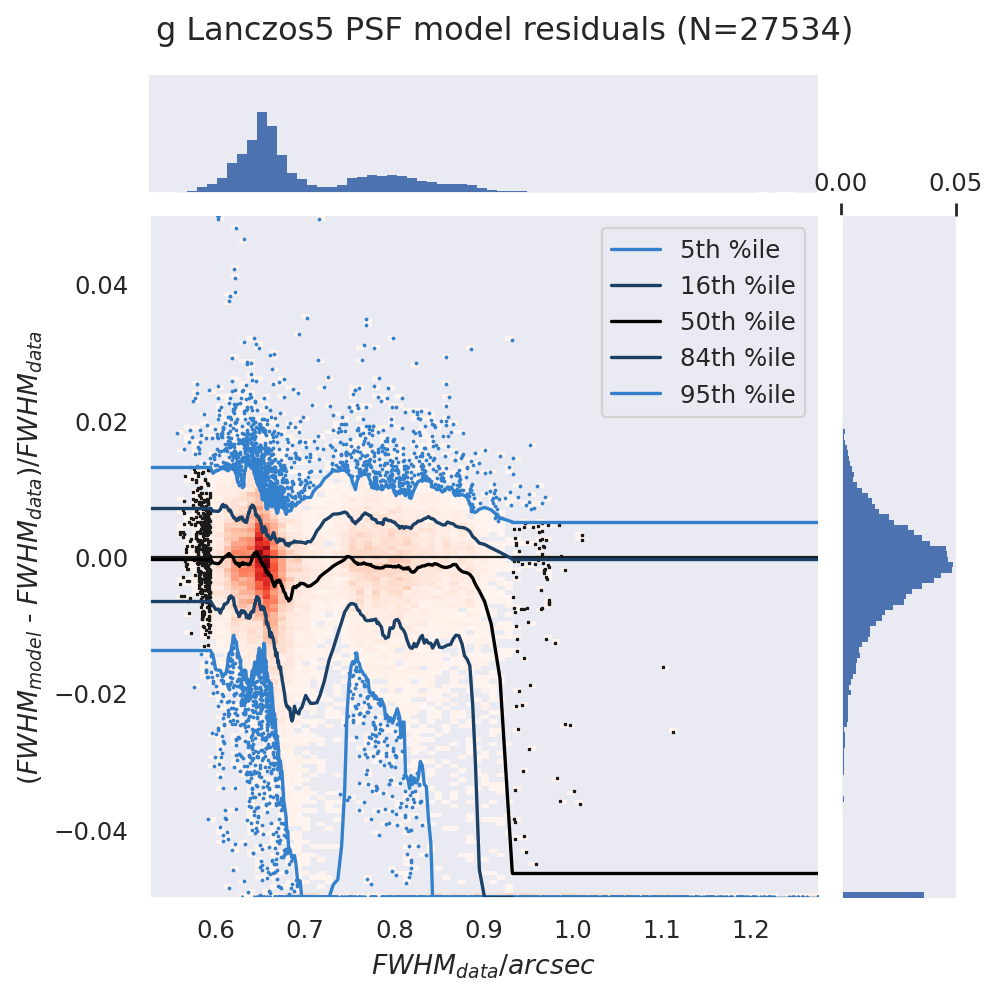

r Lanczos5 PSF model residuals (N=39198)


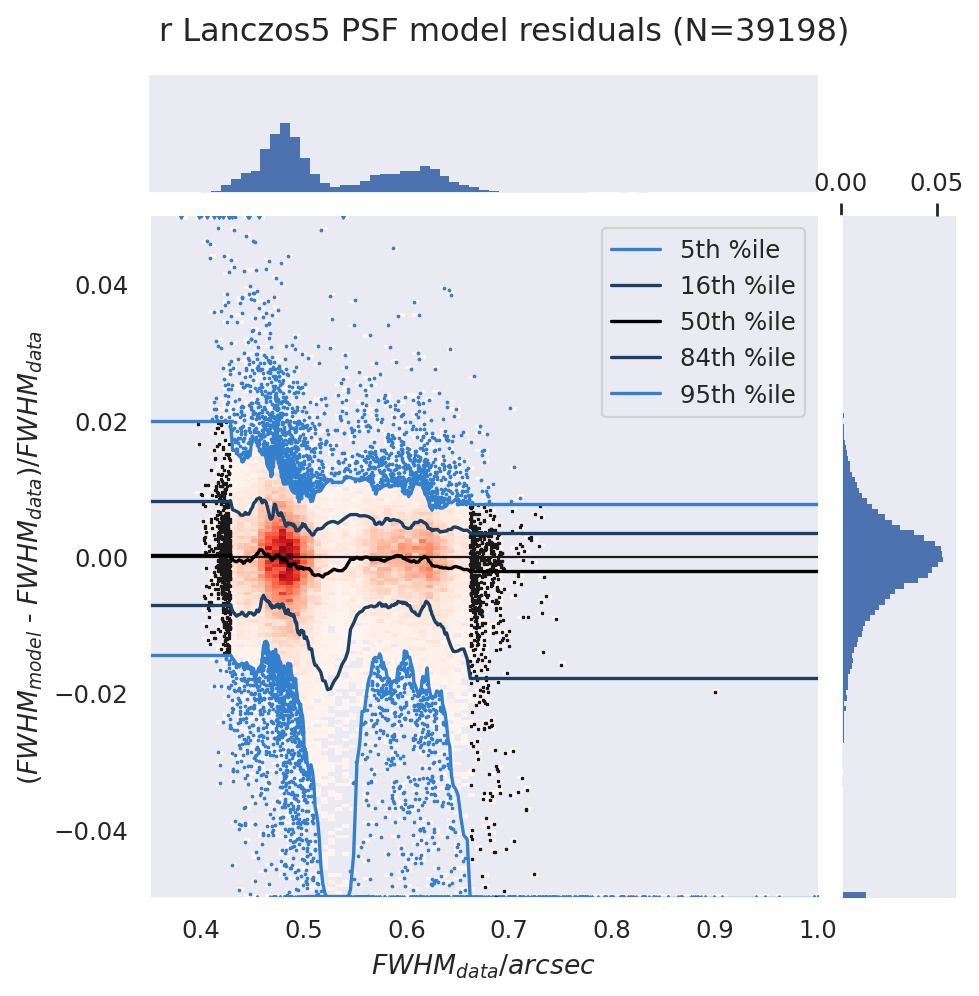

i Lanczos5 PSF model residuals (N=34261)


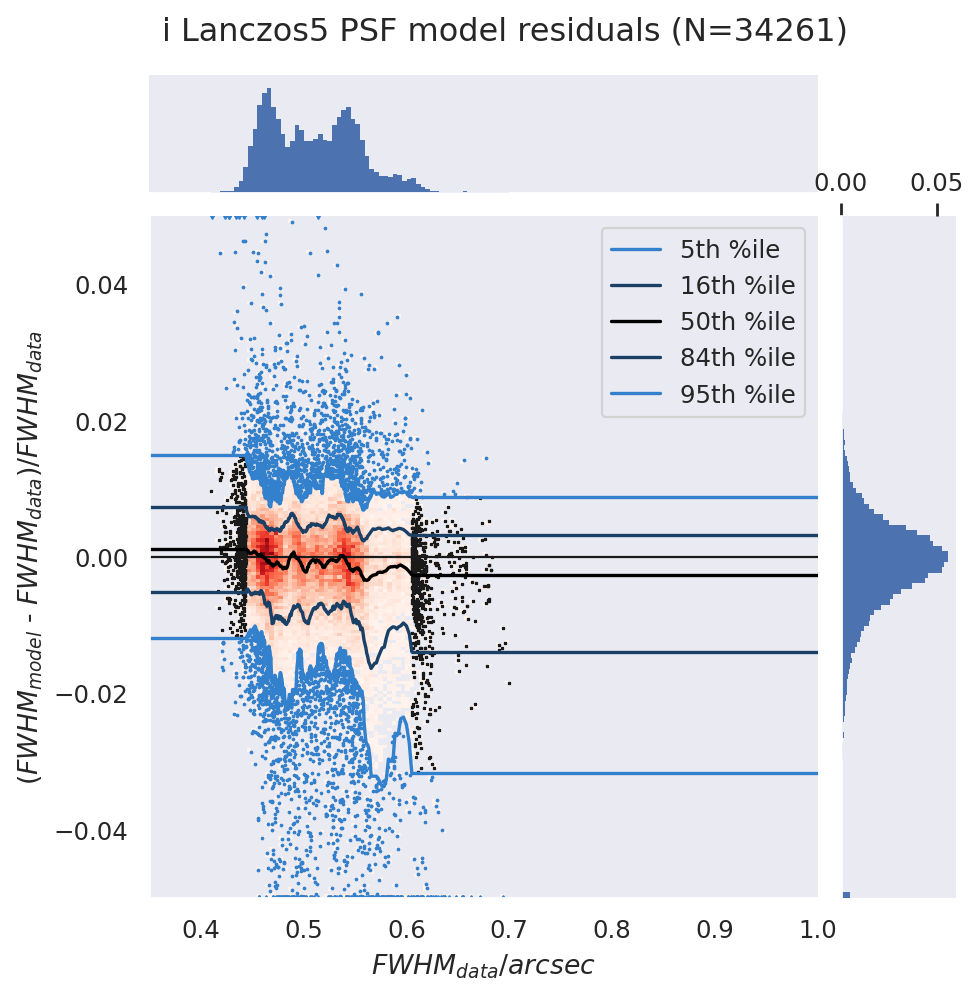

g Lanczos5, 0.556 <= FWHM <= 0.645, N=6882


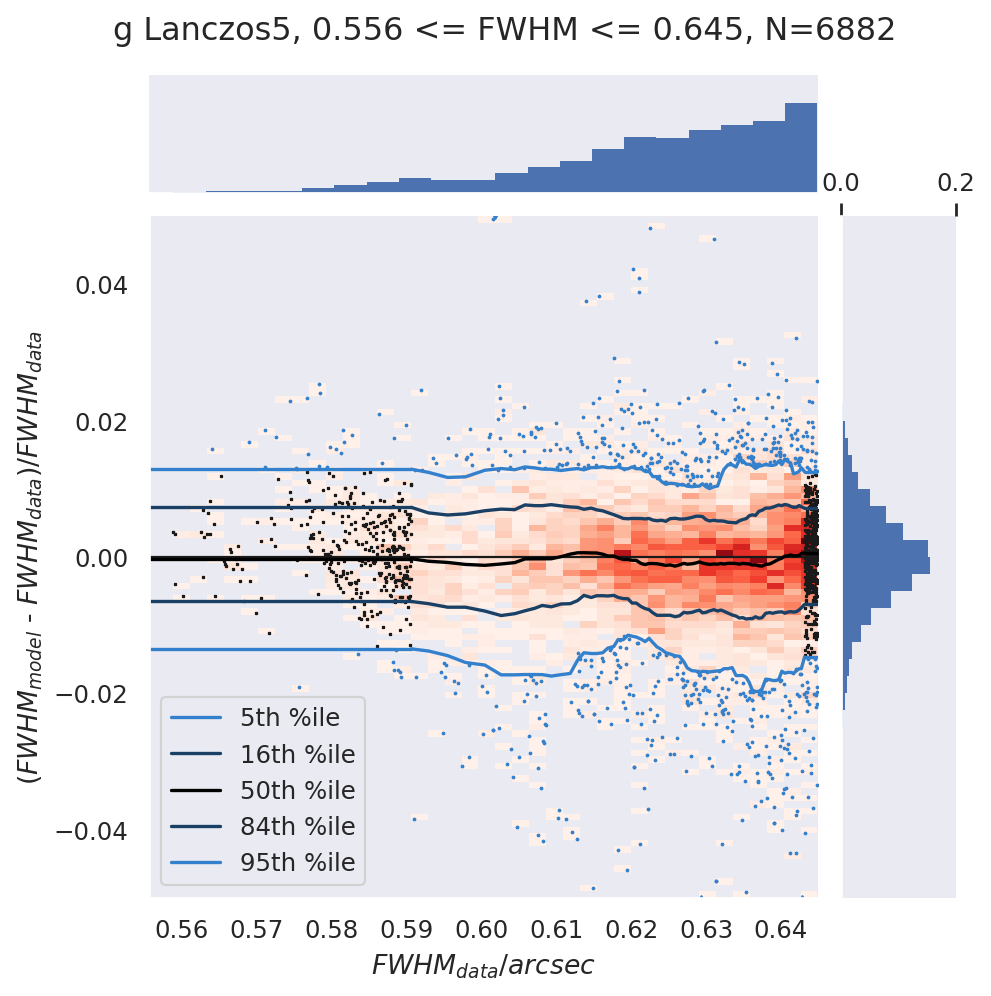

g Lanczos5, 0.645 <= FWHM <= 0.667, N=6882


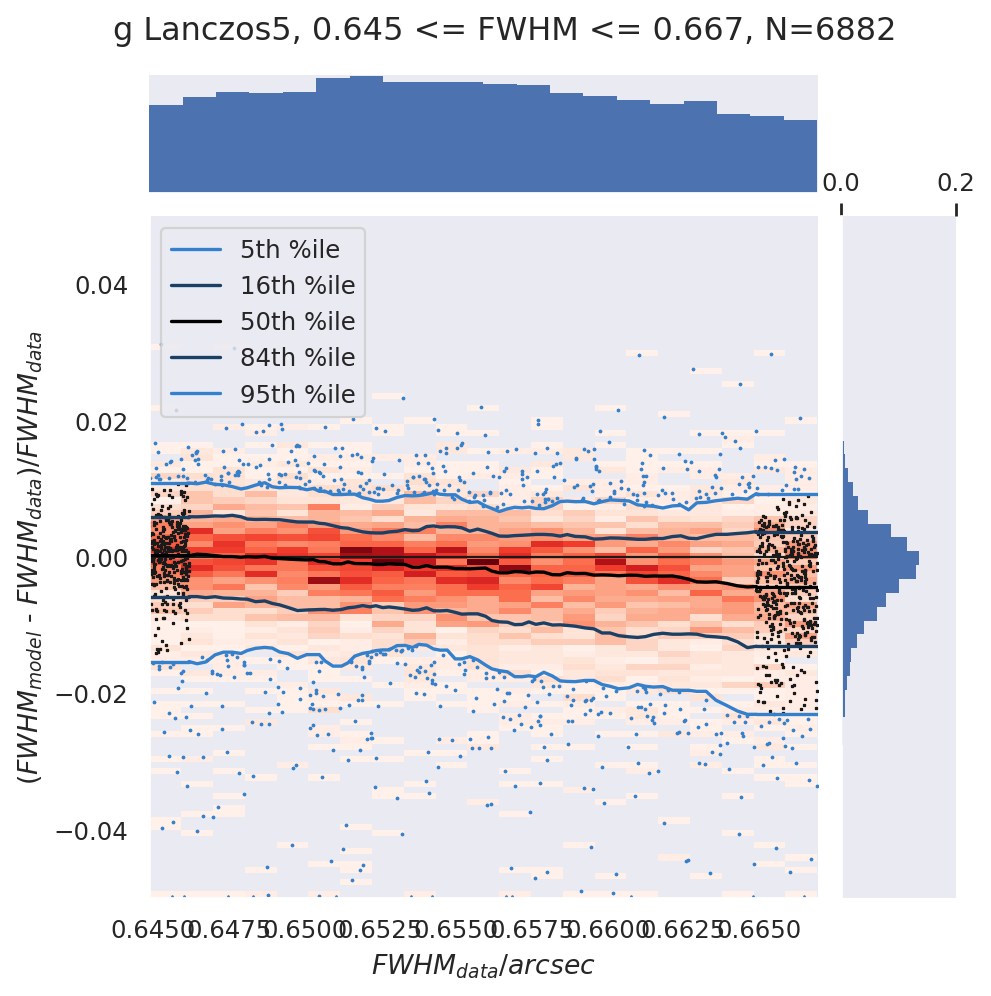

g Lanczos5, 0.667 <= FWHM <= 0.778, N=6883


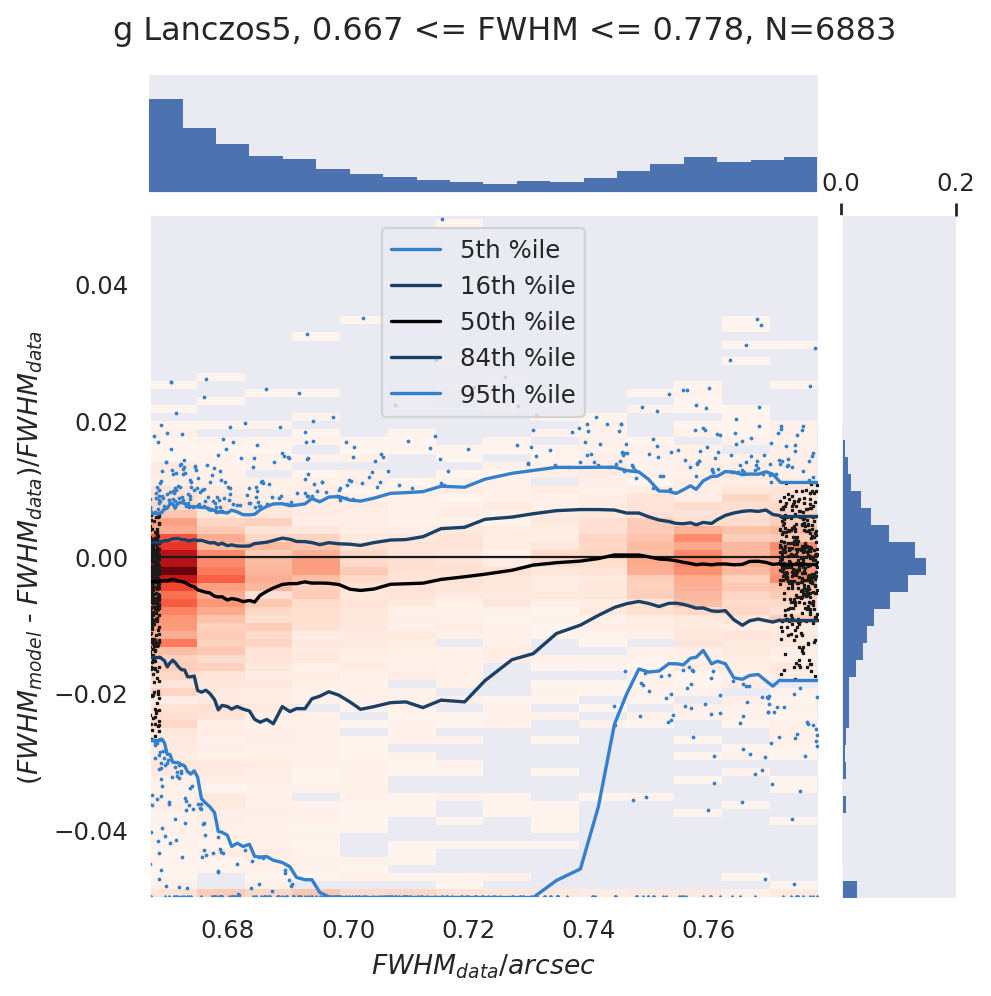

g Lanczos5, 0.778 <= FWHM <= 1.435, N=6882


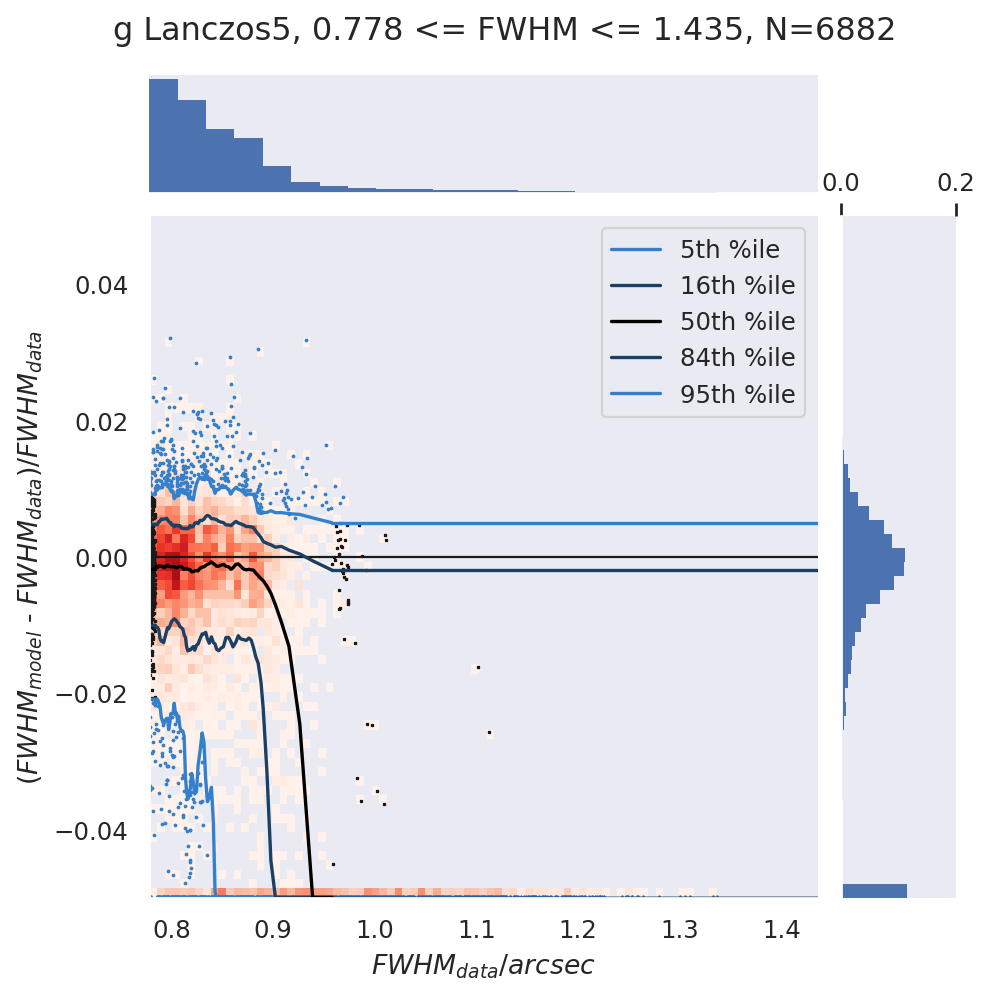

r Lanczos5, 0.381 <= FWHM <= 0.474, N=9798


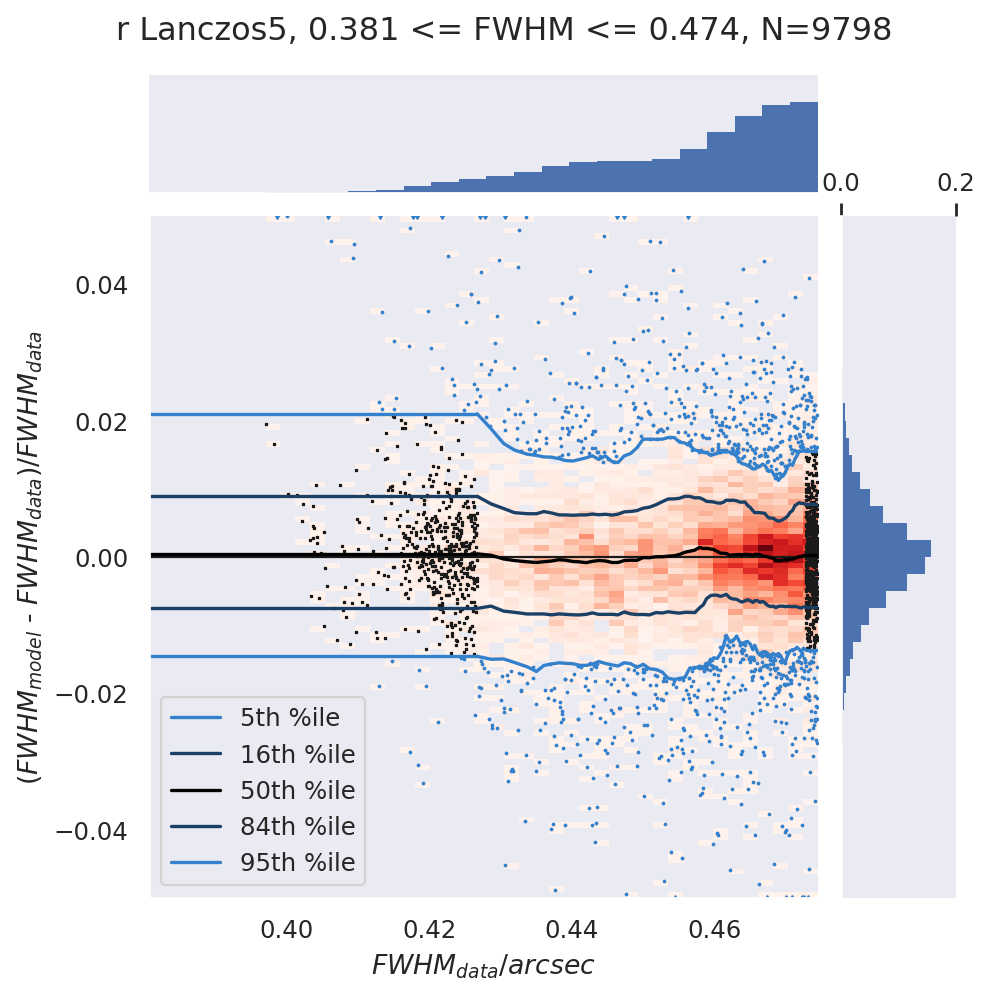

r Lanczos5, 0.474 <= FWHM <= 0.497, N=9798


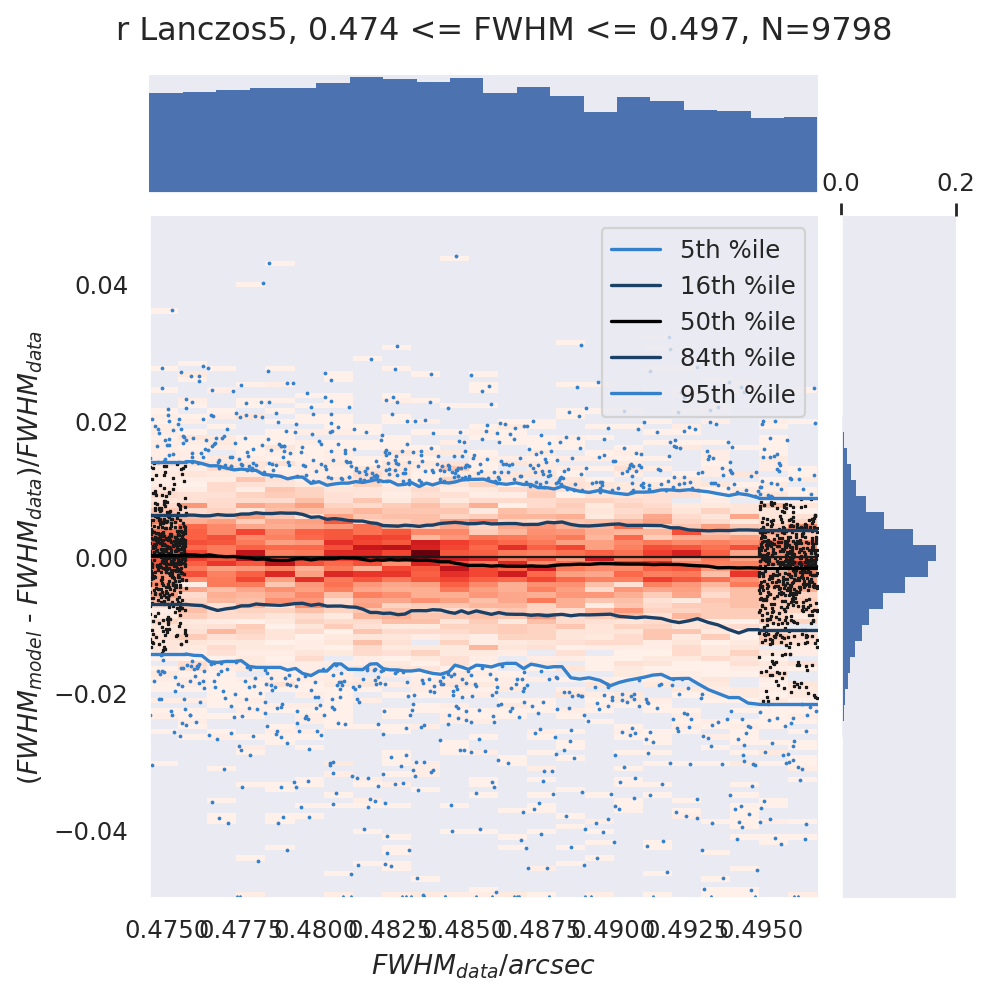

r Lanczos5, 0.497 <= FWHM <= 0.591, N=9799


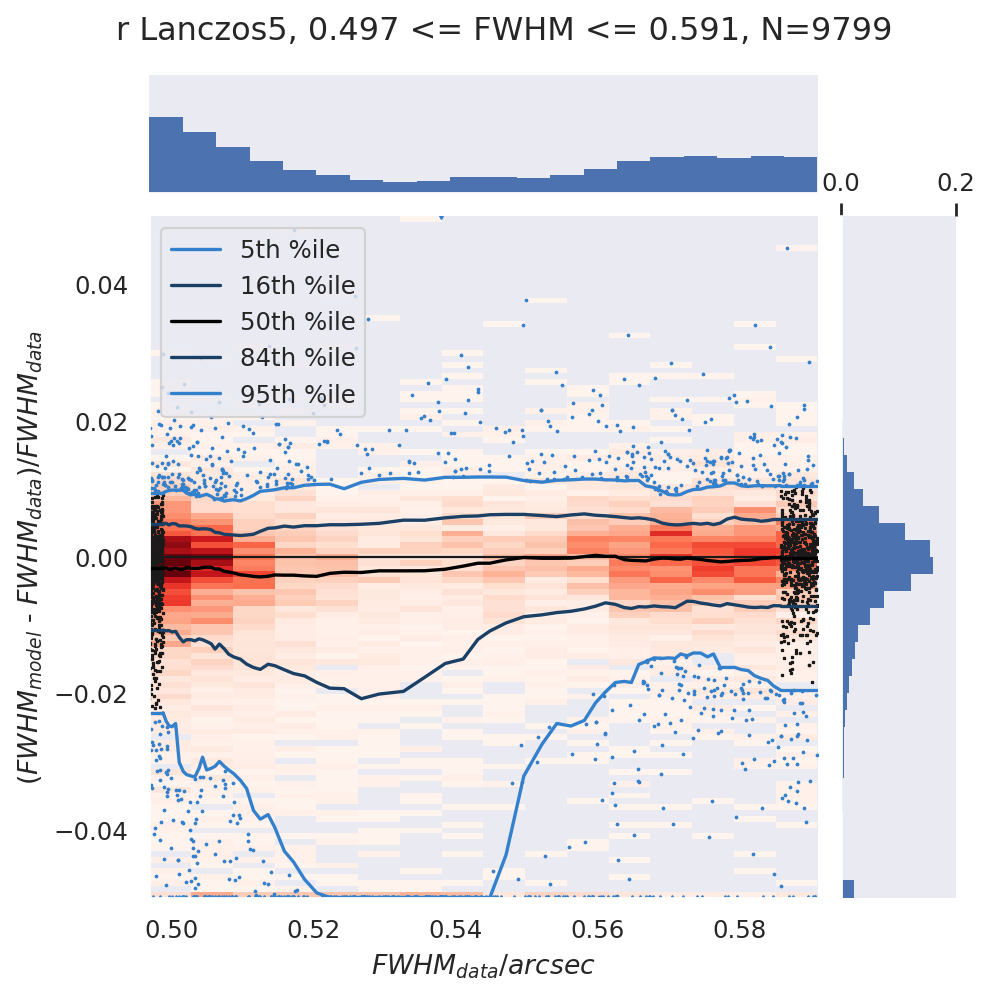

r Lanczos5, 0.591 <= FWHM <= 1.084, N=9798


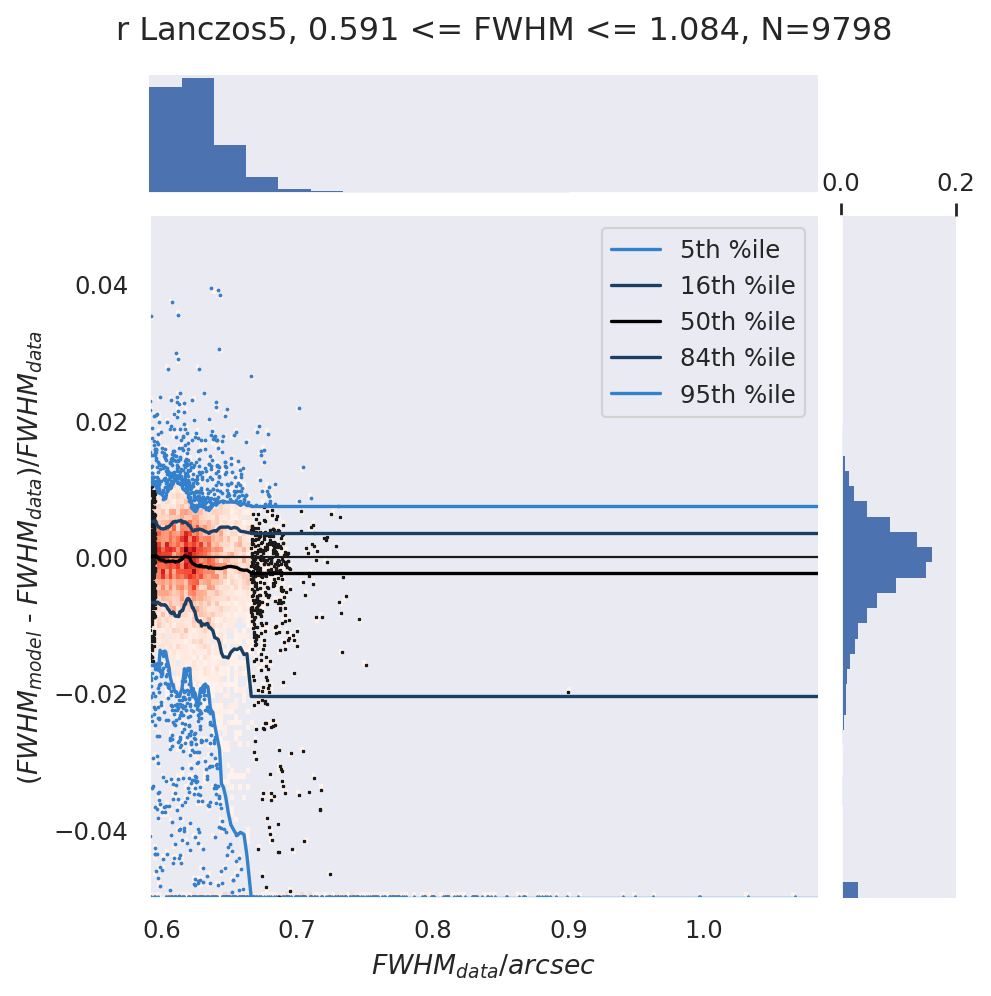

i Lanczos5, 0.410 <= FWHM <= 0.471, N=8564


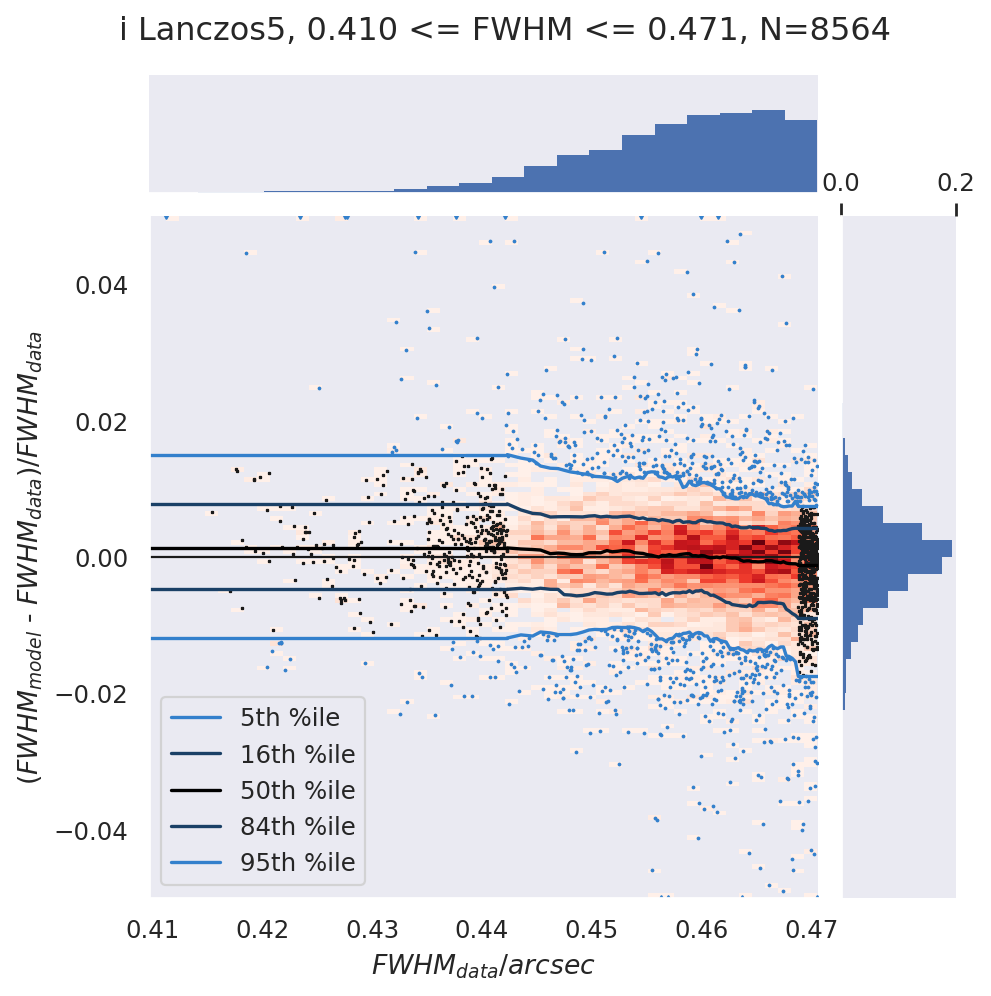

i Lanczos5, 0.471 <= FWHM <= 0.507, N=8564


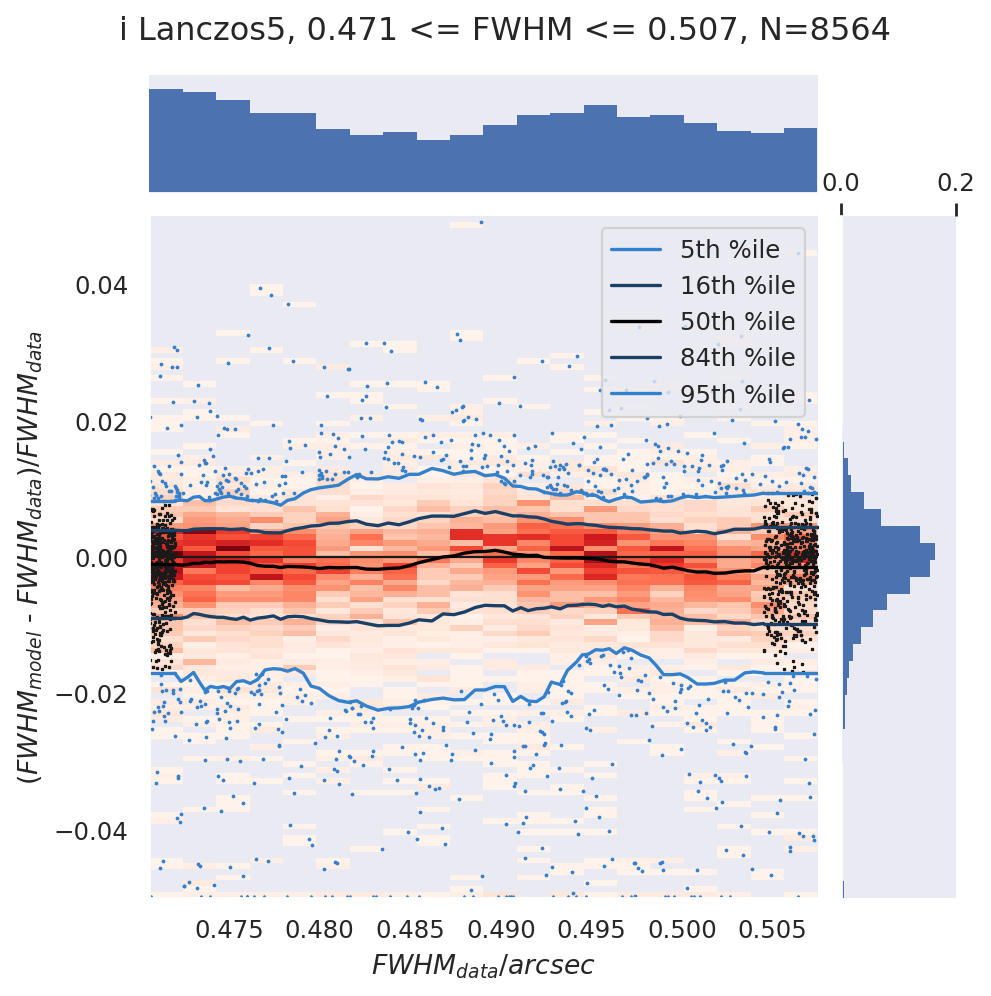

i Lanczos5, 0.507 <= FWHM <= 0.543, N=8564


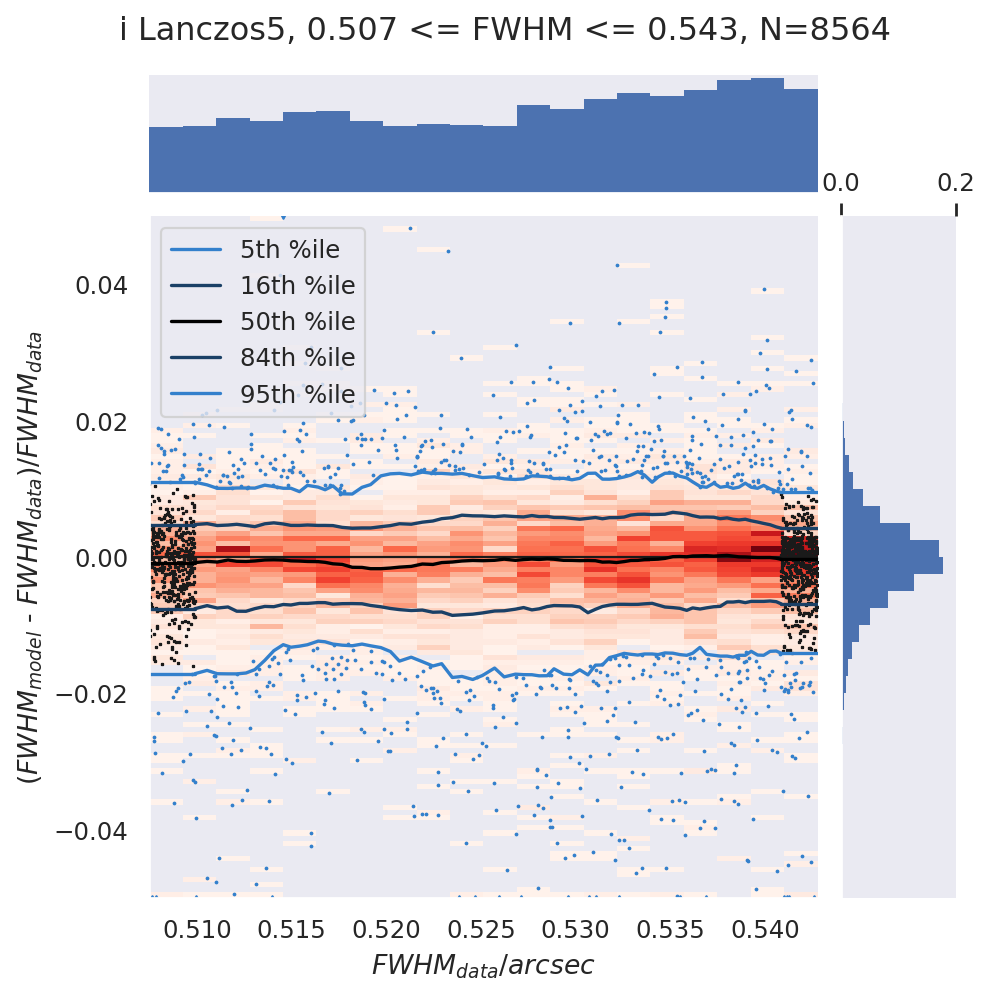

i Lanczos5, 0.543 <= FWHM <= 0.700, N=8564


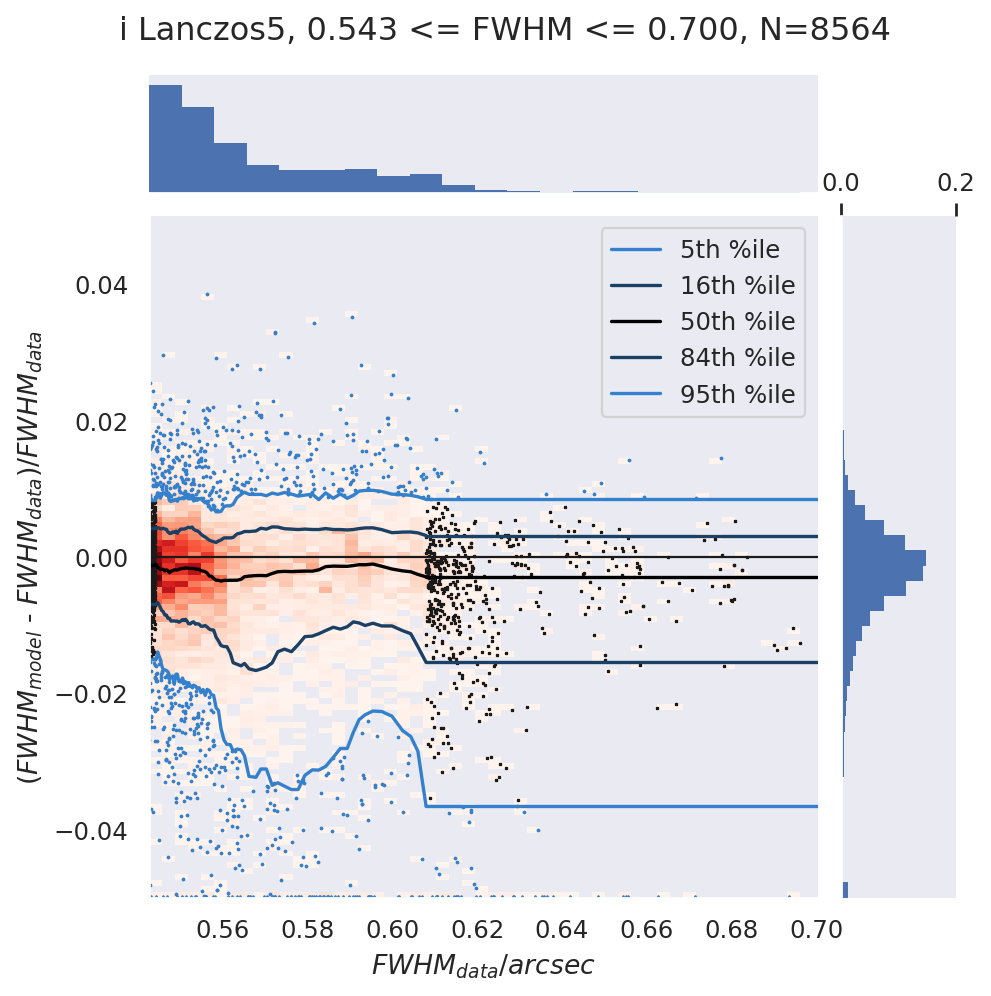

In [6]:
# Plot
kwargs_plotjoint = dict(
    nbinspan = 8,
    densityplot=sns.histplot,
    cmap='Reds',
    limy=limsfrac,
    scatterleft=True,
    scatterright=True,
)
plot_patch = False
labelflux = 'log10(instFluxPsf)'
labelsizeresid = r'($FWHM_{model}$ - $FWHM_{data}$)/$FWHM_{data}$'
labelsize = r'$FWHM_{data}/arcsec$'

for dataplot, typeofdata in ((data, 'Lanczos5'),):
    for band, limx in limxs.items():
        datum = dataplot[band]
        limx = limxs[band]
        x = np.clip(datum['starSize'], limx[0], limx[1])
        sizefrac = (datum['modelSize'] - datum['starSize'])/datum['starSize']
        title=f'{band} {typeofdata} PSF model residuals (N={len(x)})'
        print(title)
        plotjoint_running_percentiles(
            x, sizefrac, limx=limx, ndivisions=32,
            labelx=labelsize, labely=labelsizeresid, title=title,
            **kwargs_plotjoint
        )
        plt.show()
        
for dataplot, typeofdata in ((data, 'Lanczos5'),):
    for band, limx in limxs.items():
        datum = dataplot[band]
        sizefrac = (datum['modelSize'] - datum['starSize'])/datum['starSize']
        condsizefrac = np.isfinite(sizefrac) & np.isfinite(datum['fluxPsf']) & (datum['starSize']<2)
        sizebins = np.sort(datum['starSize'][condsizefrac])[
            np.asarray(np.round(np.linspace(0, np.sum(condsizefrac)-1, num=4+1)), dtype=int)
        ]
        for idx in range(len(sizebins) - 1):
            sizemin, sizemax = sizebins[idx:idx+2]
            cond = condsizefrac & (datum['starSize'] > sizemin) & (datum['starSize'] < sizemax)
            numpoints = np.sum(cond)
            title = f'{band} {typeofdata}, {sizemin:.3f} <= FWHM <= {sizemax:.3f}, N={numpoints}'
            if numpoints >= 100:    
                print(title)
                x = datum['starSize'][cond]
                y = sizefrac[cond]
                plotjoint_running_percentiles(
                    x, y, limx=(sizemin, sizemax), ndivisions=10,
                    labelx=labelsize, labely=labelsizeresid, title=title,
                    **kwargs_plotjoint
                )
                plt.show()
        if plot_patch:
            # TODO: Make sensible plots per patch
            for patch in patches:
                cond = (datum['file'] == patch) & condsizefrac
                grid = sns.jointplot(
                    np.log10(datum['fluxPsf'][cond]), sizefrac[cond], ylim=[-0.1, 0.1],
                    stat_func=None, size=4, s=1, marginal_kws={'bins': 30},
                )
                grid.fig.suptitle(band)